In [39]:
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import gensim
import plotly.graph_objects as go
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load dataset**

In [3]:
# Load train data
train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "latin1")

# Load test data
test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "latin1")

In [4]:
num_label_train = train['Sentiment'].value_counts()
num_label_test = test['Sentiment'].value_counts()

**Convert text labels to integer labels**

In [5]:
i = 0
for res in set(train["Sentiment"].values):
  train['Sentiment'][train['Sentiment'] == res] = i
  i = i + 1

i = 0
for res in set(test["Sentiment"].values):
  test['Sentiment'][test['Sentiment'] == res] = i
  i = i + 1

**Pre-Processing**

In [6]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet of Train set
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : remove_url(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : remove_emoji(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : decontraction(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : char(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x : x.lower())

# Apply functions on OriginalTweet of Test set
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : remove_url(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : remove_emoji(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : decontraction(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : char(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x : x.lower())

**Plot distribution of the classes in train set and test set**

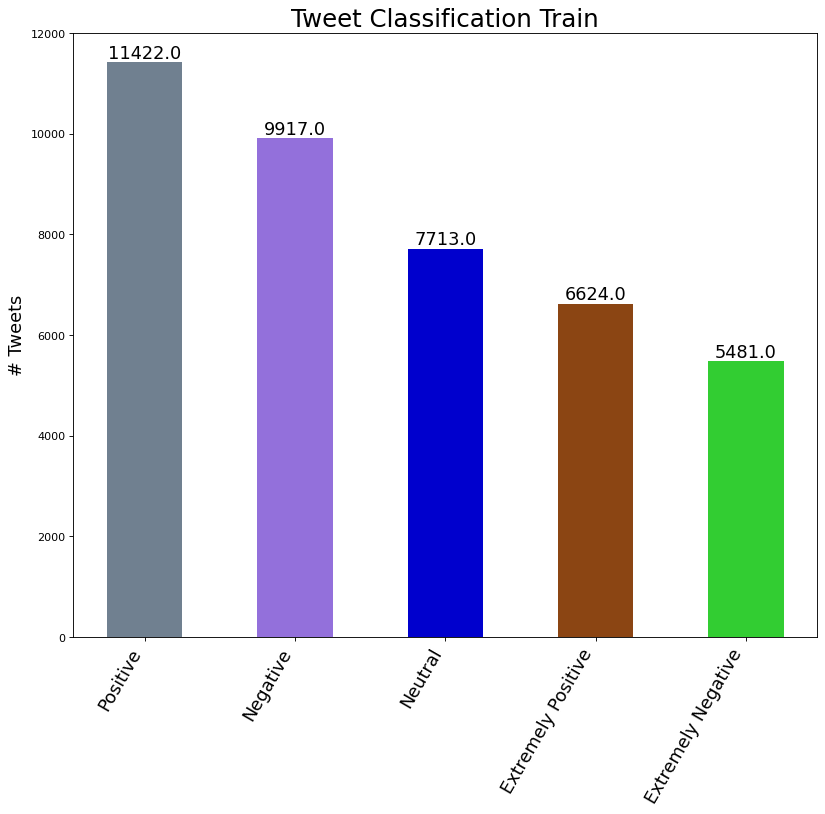

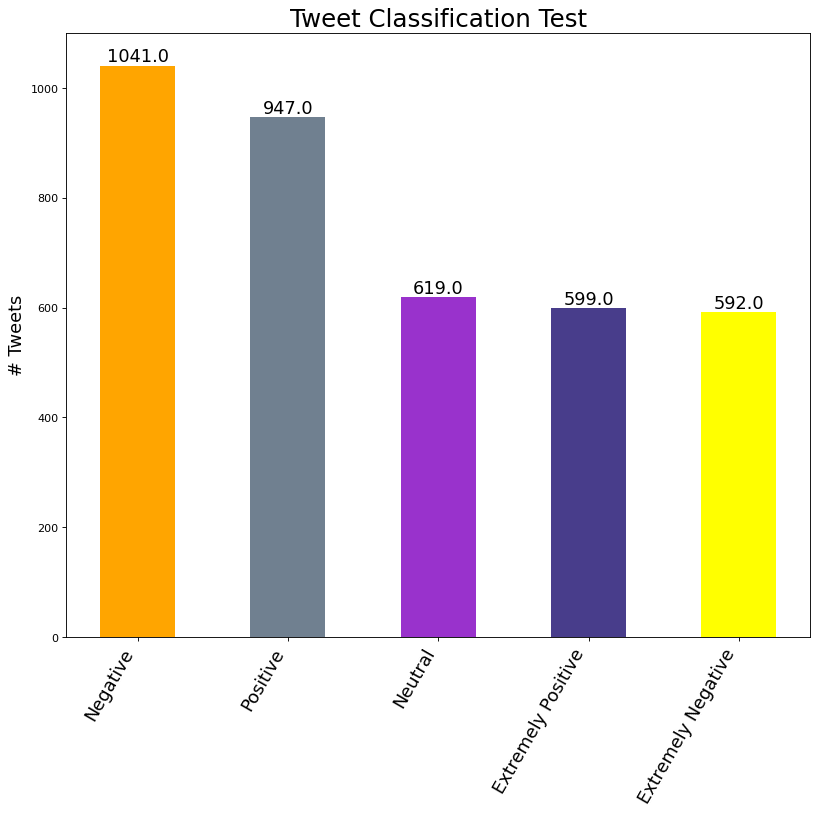

In [7]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 12000)
plot_class_dist(num_label_test.index, num_label_test.values, "Tweet Classification Test", 1100)

**Plot number of words in the tweets**

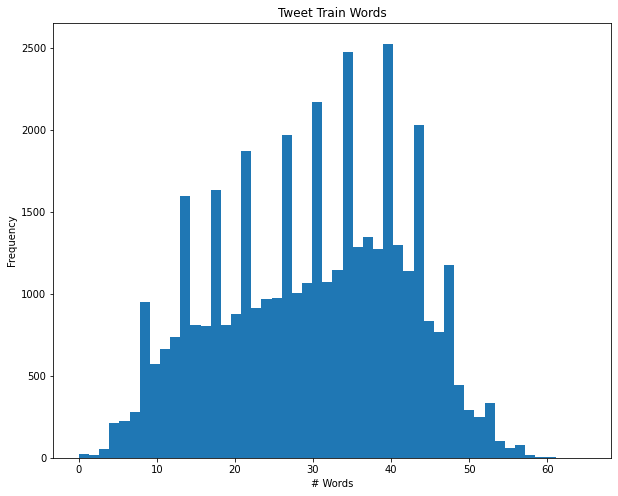

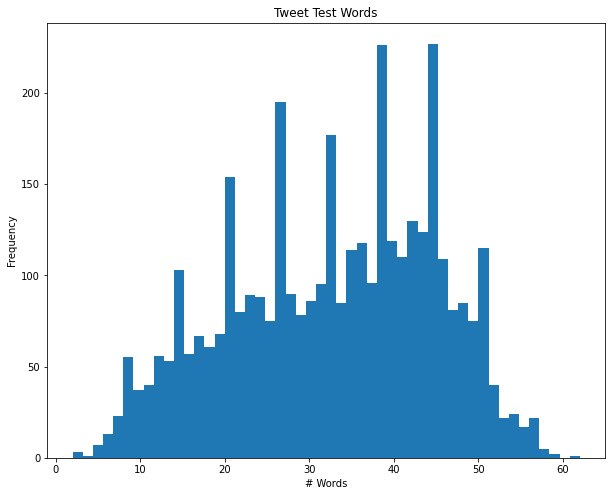

In [8]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()

test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()

**Create Vocabulary**

In [7]:
vectorizer = TfidfVectorizer(min_df=20).fit(train['OriginalTweet'].values)
x_train = vectorizer.transform(train['OriginalTweet'].values)
x_test = vectorizer.transform(test['OriginalTweet'].values)

**Baseline**

In [8]:
train["Sentiment"] = train["Sentiment"].astype('int')
test["Sentiment"] = test["Sentiment"].astype('int')

In [ ]:
gnb = MultinomialNB()
y_pred = gnb.fit(x_train.toarray(), train["Sentiment"].values).predict(x_test.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))

Number of mislabeled points out of a total 3798 points : 2137


In [ ]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

Number of mislabeled points out of a total 3798 points : 1452


0.617693522906793

In [24]:
clf = SVC(kernel='linear', max_iter=100, decision_function_shape='ovo')
scores = cross_val_score(clf, x_train.toarray(), train["Sentiment"].values, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

'''
clf.fit(x_train.toarray(), train["Sentiment"].values)
y_pred = clf.predict(x_test.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)
'''

0.35 accuracy with a standard deviation of 0.01


'\nclf.fit(x_train.toarray(), train["Sentiment"].values)\ny_pred = clf.predict(x_test.toarray())\nprint("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))\nclf.predict_proba(x_test).shape\nclf.score(x_test, test["Sentiment"].values)\n'

In [18]:
clf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators=250)
clf.fit(x_train.toarray(), train["Sentiment"].values)
y_pred = clf.predict(x_test.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test.toarray()).shape
clf.score(x_test.toarray(), test["Sentiment"].values)

Number of mislabeled points out of a total 3798 points : 2015


0.4694576092680358

**New Network**

In [41]:
X = train['OriginalTweet']
y = train['Sentiment']

# Split data into train , test
X_train , X_val , y_train , y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_test = test['OriginalTweet']
y_test = test['Sentiment']

# Convert y to categorical 
y_train = to_categorical(y_train, 5)
y_test  = to_categorical(y_test, 5)
y_val  = to_categorical(y_val, 5)

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

# convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_val_final = pad_sequences(list_tokenized_val, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

45774


In [44]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary, 300, input_length=100, trainable=True)) 

#lstm layer
model.add(LSTM(128, return_sequences=True, dropout=0.2))
#model.add(LSTM(64, return_sequences=True, dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(5,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#Print summary of model
print(model.summary())

history = model.fit(X_train_final, y_train, epochs=5, validation_data=(X_val_final, y_val))

_,test_acc = model.evaluate(X_test_final, y_test)
print(test_acc)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          13732200  
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 325       
Total params: 13,960,429
Trainable params: 13,960,429
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1029/1029 [==============================] - 56s 53ms/step - loss: 0.9587 - acc: 0.6184 - va